In [8]:
import numpy as np
import pandas as pd
import math
import time
import re
import os
from skimage import util
from scipy.io import wavfile
from scipy import signal
from scipy import stats
import xarray as xr

from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score
from sklearn.decomposition import PCA

#visualizing results
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings; warnings.simplefilter('ignore')

Create data frame of annotation info

In [4]:
features_path = 'C:/Users/Schindler/Documents/ProgrammingFun/USV_python/annot_features_full.csv'
annot_features_data = pd.read_csv(features_path)
annot_features_full = pd.DataFrame(data = annot_features_data)
print(annot_features_full.shape)
print(annot_features_full.loc[pd.isna(annot_features_full['spec_pur'])].index)
annot_features_full.dropna(axis = 0, inplace=True)
print(annot_features_full.shape)
print(annot_features_full.loc[pd.isna(annot_features_full['spec_pur'])].index)
annot_features_full.head()

(1084, 13)
Int64Index([], dtype='int64')
(1084, 13)
Int64Index([], dtype='int64')


,Unnamed: 0,Animal,Group,Annotation,time_stamp,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll
0,0,533,5,low slug,46305.0,32714.904,0.368722,39977.724643,9966.541464,2.313672,9.578221,0.000271,37978.838411
1,1,533,5,low slug,149692.5,43037.465,0.306856,37931.297975,20543.321215,4.308415,22.308306,-0.000239,36034.733076
2,2,533,5,low slug,243157.5,270193.530,0.062226,11483.575333,37201.715521,6.940257,50.135018,-0.001537,10909.396566
3,3,533,5,low slug,243270.0,63014.450,0.232295,32242.081971,21947.090189,5.325133,33.372614,-0.000671,30629.977872
4,4,533,5,low multi,295560.0,74933.164,0.206291,17095.059221,11740.918797,5.372725,34.224633,-0.001093,16240.306260


In [5]:
annot_features_full = annot_features_full[annot_features_full['Annotation'] != 'noise']

In [6]:
annot_features_full.groupby('Annotation').describe()

Unnamed: 0                                                             Animal                                                            Group                                              time_stamp                                                                                     power_sum                                                                                             spec_pur                                                                       spec_cent                                                                                                   spec_spread                                                                                                         spec_skew                                                                       spec_kurt                                                                              spec_slope                                                                       spec_roll                              \
                count        mean         std   min     25%    50%     75%    max  count        mean        std    min    25%    50%    75%    max  count      mean       std  min  25%  50%  75%  max      count           mean            std      min         25%        50%         75%       max     count           mean            std        min           25%          50%          75%        max    count      mean       std       min       25%       50%       75%       max     count          mean           std           min           25%           50%           75%           max       count           mean            std           min            25%            50%            75%            max     count      mean       std       min       25%       50%       75%       max     count       mean        std        min        25%        50%        75%        max      count      mean       std       min       25%       50%       75%       max     count          mean           std   
Annotation                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
bbc              16.0   81.875000   26.181100  21.0   76.25   84.5  101.75  107.0   16.0  551.125000   8.724487  534.0  543.0  554.0  559.0  559.0   16.0  4.437500  0.512348  4.0  4.0  4.0  5.0  5.0       16.0  222723.281250  161859.049561  13590.0  117303.750  196908.75  301685.625  535702.5      16.0  204078.307625  193322.116804  65204.582  118303.71000  157959.0050  179809.2375   872012.6     16.0  0.101816  0.046395  0.026119  0.085418  0.089934  0.118413  0.219365      16.0  31369.661776   3408.032166  25428.290261  29530.387395  31273.059220  33965.217581  36864.114756        16.0  154295.504440   45887.605222  82643.398891  124006.380527  157006.199597  171826.955013  272975.403907      16.0  4.301428  0.821950  3.272398  3.639845  4.074513  4.857638  5.614859      16.0  19.744209   8.720991  10.020710  12.778336  17.275809  25.393034  34.627316       16.0 -0.002649  0.000134 -0.002793 -0.002730 -0.002686 -0.002620 -0.002319      16.0  29801.178687   3237.630558   
high multi        5.0   60.800000   34.981424  10.0   53.00

In [9]:
orig_maj = annot_features_full[annot_features_full['Annotation'] == 'rand_noise']
orig_min = annot_features_full[annot_features_full['Annotation'] != 'rand_noise']

orig_min_upsamples = resample(orig_min, replace=True, n_samples = len(orig_maj), random_state = 123)

orig_upsamples = pd.concat([orig_min_upsamples, orig_maj])

print(orig_upsamples.Annotation.value_counts())

orig_upsamples.head()

rand_noise    900
low slug      495
bbc           154
low multi     143
high slug      73
high multi     35
Name: Annotation, dtype: int64


,Unnamed: 0,Animal,Group,Annotation,time_stamp,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll
66,66,542,4,bbc,377910.0,93180.02,0.149756,34713.561879,128074.350423,3.272398,10.020710,-0.002584,32977.883785
92,92,554,4,low slug,555637.5,110993.60,0.120054,14825.185443,46289.966503,6.002649,35.993056,-0.001519,14083.926171
98,98,555,4,bbc,401265.0,142034.19,0.093992,25535.812737,112642.483088,3.784962,13.153505,-0.002668,24259.022100
102,102,559,5,low slug,50130.0,39847.45,0.341004,34013.493164,9063.592821,2.619649,9.384766,-0.000267,32312.818506
17,17,534,5,low slug,121297.5,103066.29,0.140253,16540.820297,14643.334578,4.246245,20.080124,-0.001373,15713.779282


In [10]:
annot_features_up = orig_upsamples[['power_sum', 'spec_pur', 'spec_cent', 'spec_spread', 'spec_skew',
       'spec_kurt', 'spec_slope', 'spec_roll']]

In [11]:
# center and scale the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(annot_features_up)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
[0.3755396757774258, 0.3005434497127294, 0.35126349413230995, 0.34805738855051066, 0.35273398744091233, 0.3640429760727593, 0.37152064671494245, 0.3603421577163855, 0.37252567493832534, 0.3734734495306858, 0.36658755945821814, 0.3519253293489172, 0.3489059677671845, 0.36002723458436575, 0.3220831688375906, 0.3445198132288288, 0.35897693052860313, 0.3350303391708375]


Text(0, 0.5, 'Silhouette Coefficient')

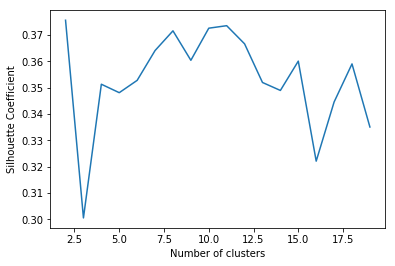

In [12]:
k_range = range(2,20)
scores = []
for k in k_range:
    print(k)
    km_ss = KMeans(n_clusters=k, random_state=19)
    km_ss.fit(features_scaled)
    scores.append(silhouette_score(features_scaled, km_ss.labels_))

print(scores)

# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')

In [13]:
km10 = KMeans(n_clusters=10,random_state=19)
km10.fit(features_scaled)
score = silhouette_score(features_scaled, km_ss.labels_)
orig_upsamples['kmeans_10_scaled'] = [ "cluster_" + str(label) for label in km10.labels_ ]
#summary_ave.groupby('kmeans_2_scaled').mean()
print(score)

0.3350303391708375


In [14]:
km2 = KMeans(n_clusters=2,random_state=19)
km2.fit(features_scaled)
score = silhouette_score(features_scaled, km_ss.labels_)
orig_upsamples['kmeans_2_scaled'] = [ "cluster_" + str(label) for label in km2.labels_ ]
#summary_ave.groupby('kmeans_2_scaled').mean()
print(score)

0.3350303391708375


In [15]:
orig_upsamples.groupby('Annotation')['kmeans_2_scaled'].value_counts()

Annotation  kmeans_2_scaled
bbc         cluster_0          154
high multi  cluster_0           25
            cluster_1           10
high slug   cluster_0           47
            cluster_1           26
low multi   cluster_0          135
            cluster_1            8
low slug    cluster_0          325
            cluster_1          170
rand_noise  cluster_1          687
            cluster_0          213
Name: kmeans_2_scaled, dtype: int64